In [215]:
import numpy as np
import pandas as pd
import pickle

# Packages for plotting
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

from modules import run_model_stochastic, initial_state_nasch, nasch_step

### CRITICAL DENSITY PLOT

/var/folders/f8/8_w9799j2wlfkyxvlcmd3z180000gn/T/ipykernel_53633/312452643.py:30: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


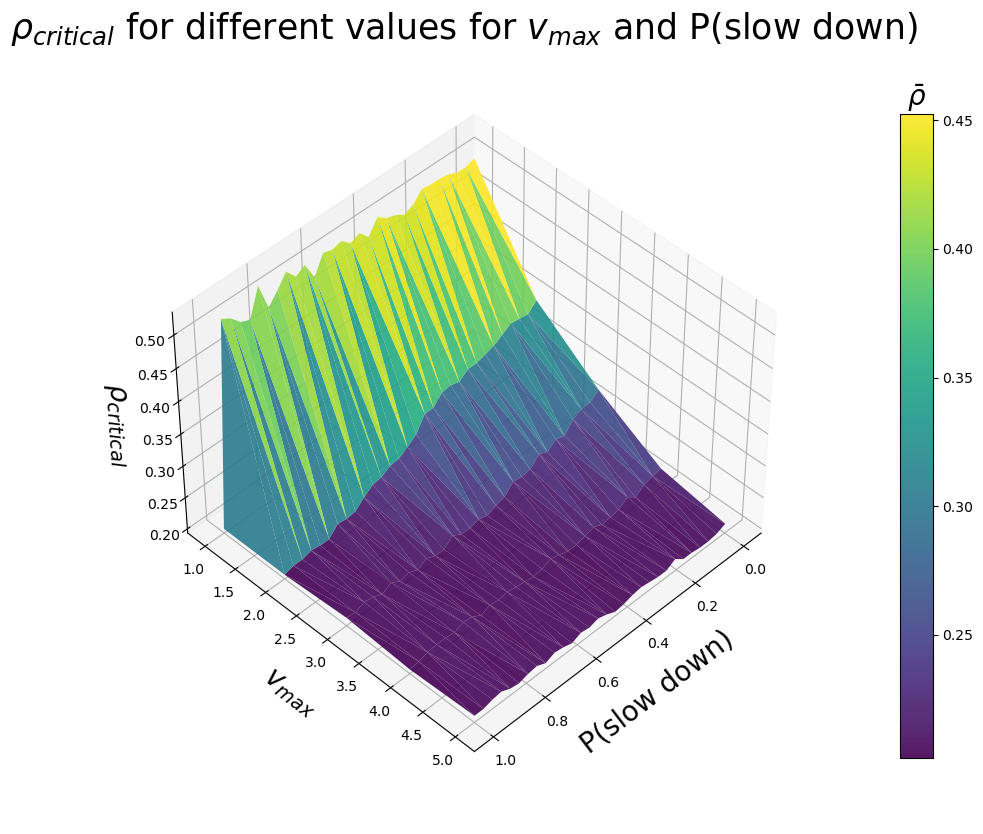

In [251]:
def plot3D(filepath):
    df = pd.read_csv(filepath)

    p_slowdown = np.array(df['p_slowdown'])
    v_max = np.array(df['v_max'])
    critical_density_raw = df['critical_density'].apply(lambda x: np.fromstring(x[1:-1], sep=',').astype(float))
    critical_density_means = np.array([np.mean(row) for row in critical_density_raw])

    triang = Triangulation(p_slowdown, v_max)

    # Create 3D plot
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_trisurf(triang, critical_density_means, shade='interp', edgecolor='k', cmap='viridis', alpha=0.9, linewidth = 0)
    # surf = ax.scatter(p_slowdown, v_max, critical_density_means, c=critical_density_means, cmap='viridis', s=50)

    # Set labels
    ax.set_xlabel(r'P(slow down)', labelpad=15, fontsize=20)
    ax.set_ylabel(r'$v_{max}$', labelpad=15, fontsize=20)
    ax.set_zlabel(r'$\rho_{critical}$', labelpad=10, fontsize=20)
    plt.title(r'$\rho_{critical}$ for different values for $v_{max}$ and P(slow down)', fontsize=25)

    # Add colorbar
    bar = fig.colorbar(surf, ax=ax, shrink=0.5)
    bar.ax.set_title(r'$\bar{\rho}$', fontsize=20)

    ax.view_init(elev=45, azim=45) 
    ax.dist = 12
    
    plt.tight_layout()
    plt.show()


filepath = 'Results/critical_densities_nasch_n=10_L=200_T=100_#p=30_reps=10.csv'
plot3D(filepath)

### MOVEMENT TOWARDS CRTIICAL DENSITY

In [ ]:
L = 300
n = 10
v_max = 5
p_slowdown = 0.3
neighbourhood_size = 10
entry_chance = 0.1
exit_chance = 0.1
dynamic_model=True

def find_density(L, p, n, v_max, p_slowdown, dynamic_model, neighbourhood_size, entry_chance, exit_chance):
    T = int(L)
    #find evolution
    current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

    evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                        dynamic_model=True, neighbourhood_size=neighbourhood_size, 
                        entry_chance=entry_chance, exit_chance=exit_chance)

    evolutions = run_model_stochastic(p=p, L=L, T=T, n_repetitions=n, v_max=v_max, p_slowdown=p_slowdown, 
                                        return_evolutions=True, dynamic_model=dynamic_model, neighbourhood_size=neighbourhood_size,
                                        entry_chance=entry_chance, exit_chance=exit_chance)[2]



    evolution = evolutions[0]
    location_evolution = [[x[0] for x in line] for line in evolution]                   #List containing the evolution of the model for each timestep.
    density_evolution = [np.sum(line) / len(line) for line in location_evolution]#      #List containing the density evolution of the model for each timestep.
    
    return density_evolution

densities_dynamic = []

for p_idx, p in enumerate(np.linspace(0.3, 0.9, 120)):
    density_dynamic = find_density(L, p, n, v_max, p_slowdown, dynamic_model, neighbourhood_size, entry_chance, exit_chance)
    densities_dynamic.append(density_dynamic)

file = open('Results/densities_dynamic.txt', 'wb')
pickle.dump(densities_dynamic, file)
file.close()

Text(0.5, 1.0, 'Evolution of $\\rho$ of cars over time')

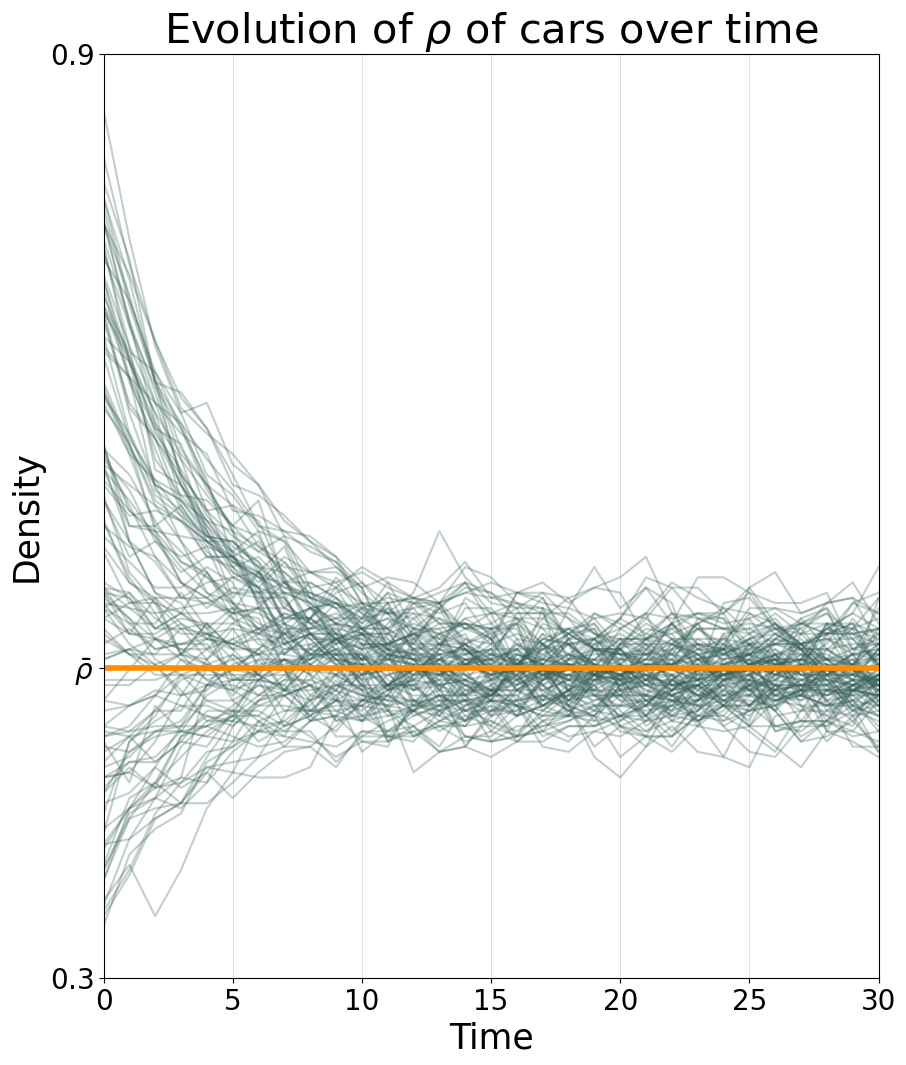

In [216]:
file = open('Results/densities_dynamic.txt', 'rb')
densities_dynamic = pickle.load(file)

plt.figure(figsize=(10,12))

for density in densities_dynamic:
    plt.plot(density, '#356058', alpha=0.3)


plt.plot([-100, 300], [np.mean(densities_dynamic), np.mean(densities_dynamic)], color='darkorange', linewidth=4)
plt.xlim(0,30)
plt.ylim(0.3,0.9)
plt.grid(alpha=0.4)
plt.xlabel('Time', fontsize=25)
plt.ylabel('Density', fontsize=25)
plt.yticks([0.3, 0.9, np.mean(densities_dynamic)], [r'$0.3$', r'$0.9$', r'$\bar{\rho}$'], fontsize=20)
plt.xticks(fontsize=20)
plt.title(r'Evolution of $\rho$ of cars over time', fontsize=30)

### DENSITY VERSUS EXIT AND ENTRY CHANCE

In [ ]:
p = 0.2 #0.13793103448275862
L = 300
n = 10

# NaSch parameters
v_max = 3
p_slowdown = 0.3

# Dynamic parameters
neighbourhood_size = 10
entry_chance = 0.1

dynamic_model=True

def find_final_density(L, p, n, v_max, p_slowdown, dynamic_model, neighbourhood_size, entry_chance, exit_chance):
    T = int(L)
    #find evolution
    current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

    evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                        dynamic_model=True, neighbourhood_size=neighbourhood_size, 
                        entry_chance=entry_chance, exit_chance=exit_chance)

    evolutions = run_model_stochastic(p=p, L=L, T=T, n_repetitions=n, v_max=v_max, p_slowdown=p_slowdown, 
                                        return_evolutions=True, dynamic_model=dynamic_model, neighbourhood_size=neighbourhood_size,
                                        entry_chance=entry_chance, exit_chance=exit_chance)[2]



    evolution = evolutions[0]
    location_evolution = [[x[0] for x in line] for line in evolution]                   #List containing the evolution of the model for each timestep.
    density_evolution = [np.sum(line) / len(line) for line in location_evolution]#      #List containing the density evolution of the model for each timestep.
    
    return(np.mean(density_evolution[L:]))

final_density_dict = {}

for ratio_idx, ratio in enumerate(np.linspace(0.1, 4, 40)):
    print(ratio_idx/20)
    final_density_column = []  # List to store values for the current ratio
    for p_idx, p in enumerate(np.linspace(0.3, 0.9, 30)):
        exit_chance = ratio * entry_chance
        final_density = find_final_density(L, p, n, v_max, p_slowdown, dynamic_model, neighbourhood_size, entry_chance, exit_chance)
        final_density_column.append(final_density)

    # Store the entire list of values for the current ratio
    final_density_dict[ratio] = final_density_column

file = open('Results/final_density_dict.txt', 'wb')
pickle.dump(final_density_dict, file)
file.close()


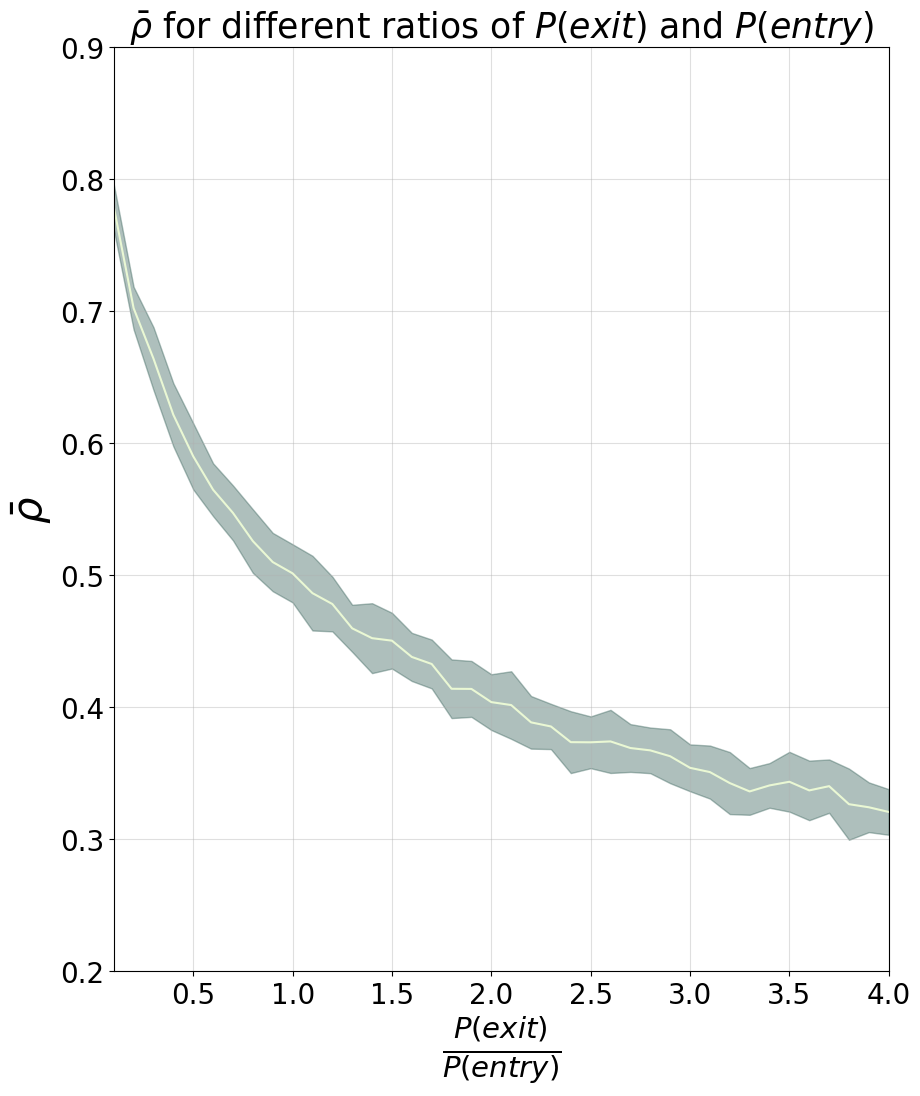

In [219]:
file = open('Results/final_density_dict.txt', 'rb')
final_density_dict = pickle.load(file)

ratios = np.linspace(0.1, 4, 40)

means = [np.mean(final_density_dict[ratio]) for ratio in ratios]
std_devs = [np.std(final_density_dict[ratio]) for ratio in ratios]

plt.figure(figsize=(10,12))

plt.plot(ratios, means, label='Final Density', color='#EAF8D4')
plt.fill_between(ratios, np.subtract(means, std_devs), np.add(means, std_devs), alpha=0.4, color='#356058')

plt.xlim(0.1,4)
plt.ylim(0.2,0.9)
plt.grid(alpha=0.4)
plt.xlabel(r'$\frac{P(exit)}{P(entry)}$', fontsize=30)
plt.ylabel(r'$\bar{\rho}$', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title(r'$\bar{\rho}$ for different ratios of $P(exit)$ and $P(entry)$', fontsize=25)

plt.show()